In [1]:
%matplotlib widget
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from _utils import ObjectTracker, Parabolic3D

%load_ext autoreload
%autoreload 2

In [2]:
TAKE_FOLDER = 'TAKE_1'

In [3]:
greenLower = (18, 86, 6)
greenUpper = (74, 255, 255)

In [4]:
if False:
    tracker = ObjectTracker(greenUpper, greenLower, TAKE_FOLDER)
    df = tracker.obj_tracker()
    df.to_csv(f'location_{TAKE_FOLDER.lower()}.csv', index=False)

# Transfer to Spatial Coordinate

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
TAKE = 1

- The frame rate is 25 fps.
- The height for both left and right camera is 110 cm and the horizontal
- distance between left and right cameras is 70 cm.
- Focal length: 6.3 mm
- CCD size: 1/2.5 in (1 cm), 5.7 mm*4.29 mm
- Image resolution: 640 * 480 pixel

In [12]:
FPS = 25 # 1/25 sec per frame
CL_LOCATION = (1.1, -0.35, 0) # meter (x: height, y: width, z: depth)
CR_LOCATION = (1.1, 0.35, 0) # meter
FOCAL_LEN = 6.3*10e-3 # meter
SENSOR_SIZE = (5.7*10e-3, 4.29*10e-3) # meter (W, H)
IMG_RESOLUTION = (640, 480) # px (W, H)

In [13]:
def get_XYZ(df, **kwargs):
    (xl, yl) = (df.loc[df['camera'] == 'L', 'x'].values[0], df.loc[df['camera'] == 'L', 'y'].values[0]) # px (W, H)
    (xr, yr) = (df.loc[df['camera'] == 'R', 'x'].values[0], df.loc[df['camera'] == 'R', 'y'].values[0])
    
    # transfer px to meter and shift to center
    sensor_size = kwargs['sensor_size']
    img_res = kwargs['img_res']
    (xc, yc) = (sensor_size[0]//2, sensor_size[1]//2)
    (xl, yl) = (xl*sensor_size[0]/img_res[0] - xc, - yl*sensor_size[1]/img_res[1] - yc)
    (xr, yr) = (xr*sensor_size[0]/img_res[0] - xc, - yr*sensor_size[1]/img_res[1] - yc)
    
    # print(f'take_{ df["take"].values[0] } frame_{ df["frame_num"].values[0] }')
    # print((xl, yl)) 
    # print((xr, yr))

    cl_loc = kwargs['cl_loc']; cr_loc = kwargs['cr_loc'] # (H, W, D)
    beta = np.abs(cl_loc[1]-cr_loc[1])

    ZZ = kwargs['focal_len'] * beta / (xl - xr)
    XX = kwargs['focal_len'] * yr / (xl - xr)   # x in image is different from real coordinate (x, y exchange)
    YY = kwargs['focal_len'] * xr / (xl - xr)
    (XX, YY, ZZ) = (XX+1.1, YY+0.35, ZZ)
    df['XX'] = XX
    df['YY'] = YY
    df['ZZ'] = ZZ
    return df

TAKE_1, Landing Point:[ 0.    1.23 22.34], vf: [-0.02918431  0.01605787  0.39786563], |vf|: 0.399257607300072


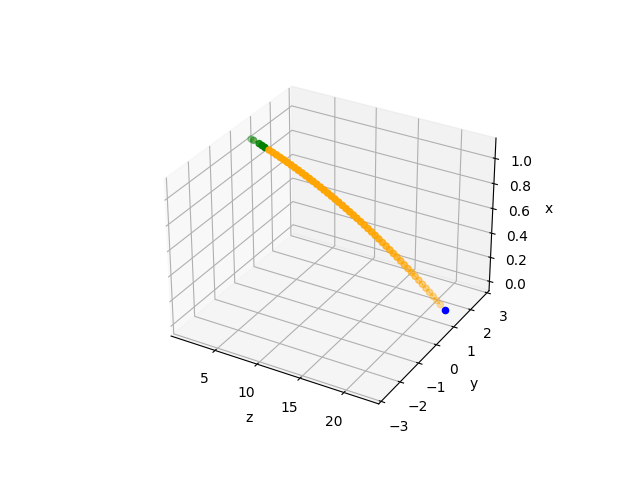

In [14]:
df = pd.read_csv(f'location_take_{TAKE}.csv')

frame_nums = df['frame_num'].unique()
frame_nums.sort()
cameras = df['camera'].unique()
cameras.sort()

tracked = []
for f in frame_nums:
    df_slice = df[df['frame_num'] == f].copy()
    params = {
        'cl_loc': CL_LOCATION,
        'cr_loc': CR_LOCATION,
        'focal_len': FOCAL_LEN,
        'sensor_size': SENSOR_SIZE,
        'img_res': IMG_RESOLUTION,
    }

    df_slice = get_XYZ(df_slice, **params)
    (XX, YY, ZZ) = (df_slice['XX'].values[0], df_slice['YY'].values[0], df_slice['ZZ'].values[0])
    # print((XX, YY, ZZ))
    tracked.append([XX, YY, ZZ])

tracked = np.array(tracked)

#### fitting ####
model = Parabolic3D()
xyz = np.concatenate([tracked[:,0], tracked[:,1], tracked[:,2]])
t = np.arange(len(tracked))
model.fit(t, xyz)
weights = model.get_params()

# print(weights)

#### find t when x = 0 (landing points) ####
# => find root of w[0] + w[1]*t + w[2]*t^2 = 0
r1 = (-weights[1]+np.sqrt(weights[1] ** 2 - 4 * weights[2] * weights[0]))/(weights[2]*2)
r2 = (-weights[1]-np.sqrt(weights[1] ** 2 - 4 * weights[2] * weights[0]))/(weights[2]*2)
t_landing = r1 if r1 >= 0 else r2
t_landing = np.array([t_landing])
point_landing = model.predict(t_landing).reshape(3, -1)
point_landing = point_landing[:,0]

#### find the final velocity vf ####
dt = 0.1*FPS # sec
point_landing_next = model.predict(t_landing+dt).reshape(3, -1)
point_landing_next = point_landing_next[:,0]
dx = point_landing_next - point_landing
vf = dx/dt
vf_mag = np.sqrt(vf[0]**2+vf[1]**2+vf[2]**2)

#### Answer ####
print(f'TAKE_{TAKE}, Landing Point:{np.round(point_landing,2)}, vf: {vf}, |vf|: {vf_mag}')

#### plot the estimate path ####
t_est = np.arange(0, int(t_landing), 1)
xyz_est = model.predict(t_est).reshape(3, -1)

#### visualize ####
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot(xyz_est[2, :], xyz_est[1, :], xyz_est[0, :], color="orange", label="fitted data", linestyle='--', linewidth='0.5')
ax.scatter(xyz_est[2, 5:], xyz_est[1, 5:], xyz_est[0, 5:], color="orange")
ax.scatter(tracked[:,2], tracked[:,1], tracked[:,0],color='green')
ax.scatter(point_landing[2], point_landing[1], point_landing[0], color="blue", label="landing point")
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')
ax.set_ylim(-3,3)
plt.show()